# Classifying Fashion-MNIST

I am using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. Fashion-MNIST is a set of 28x28 greyscale images of clothes.
loading the dataset through torchvision.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Defining a function to display an image using Matplotlib

In [2]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Here we can see one of the images.

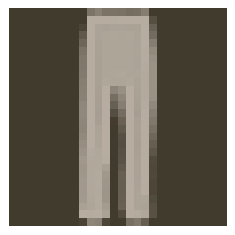

In [3]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

## Building the network

As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. The layer has 3 hidden layers and one output layer. The activation function used for hidden layers is ReLU, and for the output layer is log softmax.

In [4]:
from torch import nn, optim
import torch.nn.functional as F

In [5]:
# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

# Train the network

I am creating a network and training it. I am defining loss to be NLLLoss(negative log likelihood loss) and I am using optimizer to be ADAM.

The training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

I am running on 30 epochs and noting down training and test losses after each epoch.

In [6]:
# Create the network, define the criterion and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [7]:
# Train the network here
epochs = 30
train_losses = []
test_losses = []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.481..  Test Accuracy: 0.830
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.471..  Test Accuracy: 0.837
Epoch: 3/30..  Training Loss: 0.357..  Test Loss: 0.398..  Test Accuracy: 0.862
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.381..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.314..  Test Loss: 0.373..  Test Accuracy: 0.869
Epoch: 6/30..  Training Loss: 0.300..  Test Loss: 0.376..  Test Accuracy: 0.871
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.365..  Test Accuracy: 0.868
Epoch: 8/30..  Training Loss: 0.282..  Test Loss: 0.355..  Test Accuracy: 0.877
Epoch: 9/30..  Training Loss: 0.270..  Test Loss: 0.370..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.262..  Test Loss: 0.370..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.364..  Test Accuracy: 0.879
Epoch: 12/30..  Training Loss: 0.251..  Test Loss: 0.379..  Test Accuracy: 0.873
Epoch: 13/30..  Training Loss: 0.241.

This is a helper function to display an image and its predicted class

In [8]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Testing the network.

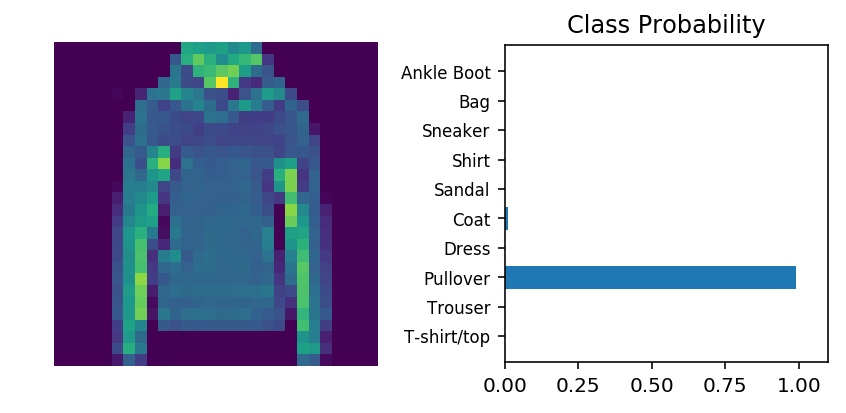

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]


ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img, ps, version='Fashion')